cuda


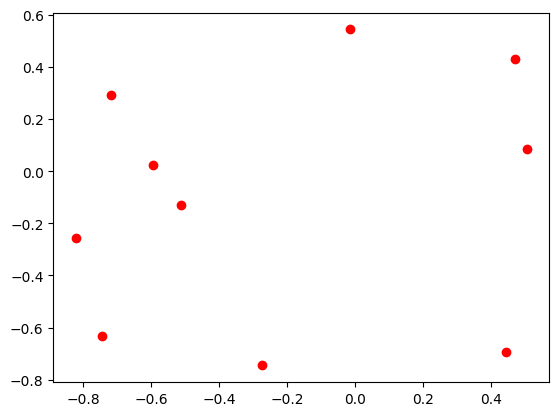

In [81]:
import numpy
import numpy as np
import torch
from torch import nn
import random
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import math
from sklearn import preprocessing

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Only take the 4 biggest points
def transform_data(data_array):
    vec = []
    data_array = data_array['dgms']
    for i in range(len(data_array)-1, -1, -1):
        array = data_array[i]
        for j in range (len(array)-1, -1, -2):
            if array[j][1] == float('inf'):
                continue
            #vec.append(array[j][0])
            vec.append(array[j][1])
            if len(vec) == 5:
                return vec


def sample_circle(amount_samples):
    sample = []
    for i in range(amount_samples):
        r = 1 * math.sqrt(random.random())
        theta = random.random() * 2 * math.pi
        sample.append((r * math.cos(theta), r * math.sin(theta)))

    return np.array(sample)



def sample_torus(amount_samples):
    sample = []
    for i in range(amount_samples):
        U = random.random()
        R = math.sqrt(U*(0.5**2)+ (1-U)*(1**2))
        theta = 360 * random.random()
        sample.append((R * math.cos(theta), R*math.sin(theta)))

    return np.array(sample)


def my_plot(epochs, loss):
    plt.plot(epochs, loss)


def plot(trainer):
    figure, axes = plt.subplots()
    uc_3 = plt.Circle(trainer.c, trainer.R, fill=False)

    new_x = []
    new_y = []

    for data in tensors_circle:
        map = dsvdd.forward(data).cpu().detach().numpy()
        new_x.append(map[0])
        new_y.append(map[1])

    an_x = []
    an_y = []

    for outlier in tensors_torus:
        outlier_pos = dsvdd.forward(outlier).cpu().detach().numpy()
        an_x.append(outlier_pos[0])
        an_y.append(outlier_pos[1])

    center = dsvdd_trainer.c.cpu().detach().numpy()
    plt.scatter(new_x, new_y,
                           color="green", s=5)
    plt.scatter(an_x, an_y,
                color="red", s=5)
    plt.scatter(center[0], center[1],
                color="blue", s=5)
    axes.add_artist(uc_3)
    plt.gca().add_patch(uc_3)
    plt.axis('equal')
    plt.show()

samples = sample_torus(10)
plt.scatter(samples[:,0], samples[:,1], color="red")

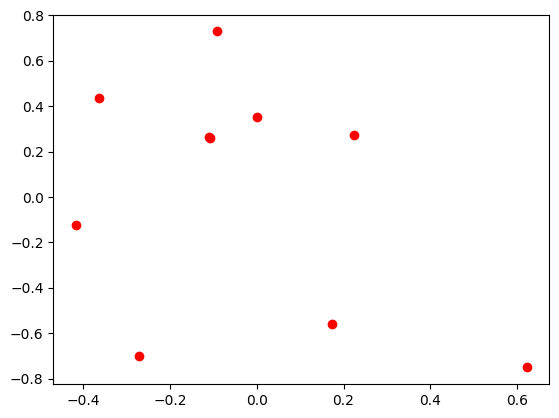

In [82]:
samples_circle = sample_circle(10)
plt.scatter(samples_circle[:,0], samples_circle[:,1], color="red")

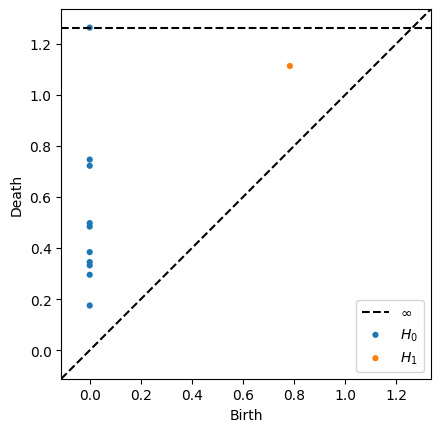

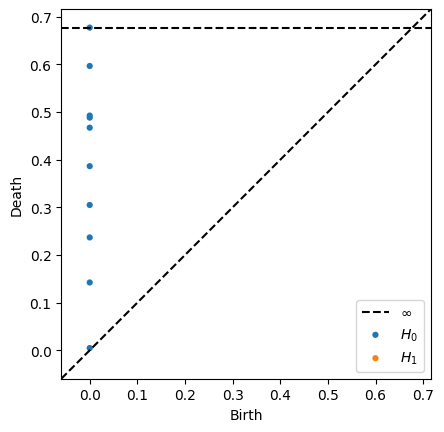

In [83]:
data_torus = ripser(samples)
data_circle = ripser(samples_circle)
plot_diagrams(data_torus['dgms'], show=True)
plot_diagrams(data_circle['dgms'], show = True)

In [84]:
trainings_data_circle = []
data_torus = []

processed_data_torus = []
processed_data_circle = []
for i in range(1000):
    trainings_data_circle.append(ripser(sample_circle(10)))


for i in range(500):
    data_torus.append(ripser(sample_torus(10)))

scaled_data_circle = []
scaled_data_torus = []
#for l,k in zip(trainings_data_circle, data_torus):
#    print(l, k)




for d in trainings_data_circle:
    if  (t_d := transform_data(d)) is not None:
        processed_data_circle.append(t_d)
for d in data_torus:
    if (t_d := transform_data(d)) is not None:
        processed_data_torus.append(t_d)

scaler = preprocessing.MinMaxScaler().fit(processed_data_circle)

scaled_data_circle = scaler.fit_transform(processed_data_circle)
scaled_data_torus = scaler.fit_transform(processed_data_torus)

tensors_circle = []
tensors_torus = []

for d in scaled_data_circle:
    tensors_circle.append(torch.tensor(d, dtype=torch.float32, device=device))

for d in scaled_data_torus:
    tensors_torus.append(torch.tensor(d, dtype=torch.float32, device=device))


[[0.41734887 0.32132367 0.31588668 0.39954973 0.35490364]
 [0.91796902 0.60193167 0.34921589 0.42208755 0.08285756]
 [0.85365366 0.49447751 0.42792297 0.43540657 0.15275011]
 ...
 [0.60431729 0.68313626 0.12448561 0.2894403  0.28238774]
 [0.55026984 0.56524333 0.6786113  0.42110615 0.37240571]
 [0.47366712 0.33908725 0.16648005 0.36095865 0.2838954 ]]
[[0.83420853 0.60412941 0.72676827 0.63605501 0.65354556]
 [0.61424278 0.41365036 0.49080725 0.68035085 0.42204482]
 [0.6111774  0.47285712 0.8036978  0.53292273 0.35718434]
 ...
 [0.5907166  0.33190695 0.40081006 0.48712692 0.59869049]
 [0.79048878 0.65771825 0.61115973 0.25475678 0.33744291]
 [0.68651394 0.15429309 0.54485374 0.17534973 0.25476266]]


In [85]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            nn.Linear(5, 5, bias=False),
            nn.LeakyReLU(),
            nn.Linear(5, 5, bias=False),
            nn.LeakyReLU(),
            nn.Linear(5, 2, bias=False),
            nn.LeakyReLU(),
            nn.Linear(2, 5, bias=False),
            nn.LeakyReLU(),
            nn.Linear(5, 5, bias=False),
            nn.LeakyReLU(),
            nn.Linear(5, 5, bias=False),
        ).to(device)

    def forward(self, x):
        return self.layers(x)


class AETrainer:
    def __init__(self, model):
        self.model = model

    def train(self, training_data, epochs):
        train_loader = torch.utils.data.DataLoader(list(zip(training_data, training_data)), batch_size=1, shuffle=True)
        loss_function = nn.L1Loss(reduction='sum').to(device)
        optimizer = torch.optim.SGD(self.model.parameters(), lr=1e-4)
        losses = []
        for epoch in range(0, epochs):
            epoch_loss = []
            for i, data in enumerate(train_loader, 0):
                inputs, targets = data
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = loss_function(outputs, targets) * loss_function(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_loss.append(loss.item())
            losses.append(sum(epoch_loss) / len(epoch_loss))
        return losses

    def model(self):
        return self.model()

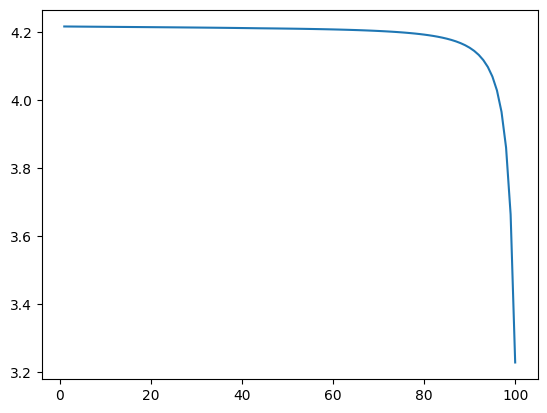

In [86]:
ae = AutoEncoder()
ae_trainer = AETrainer(ae)
epochs = 100
losses = ae_trainer.train(tensors_circle, epochs)
my_plot(np.linspace(1, epochs, epochs).astype(int), losses)

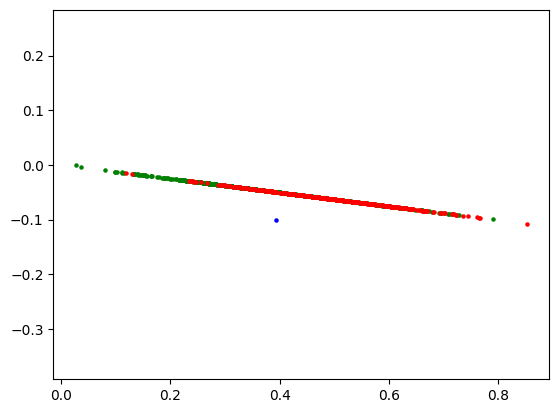

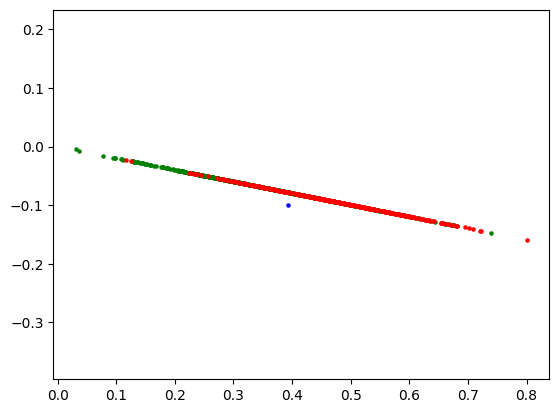

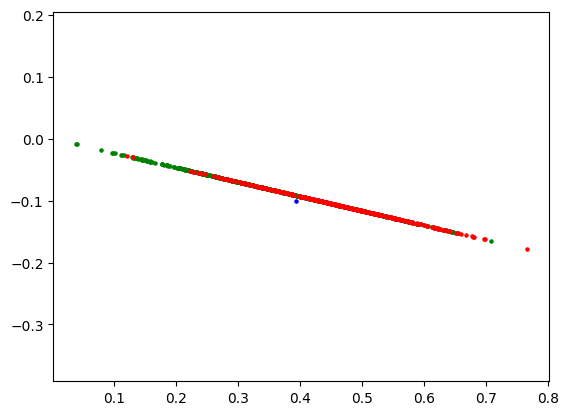

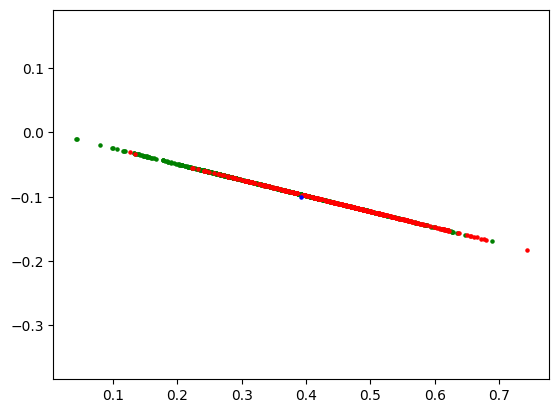

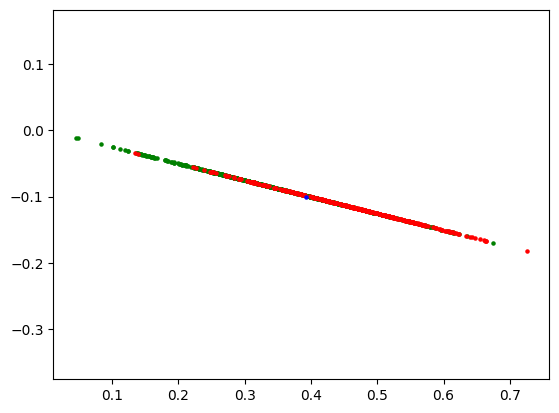

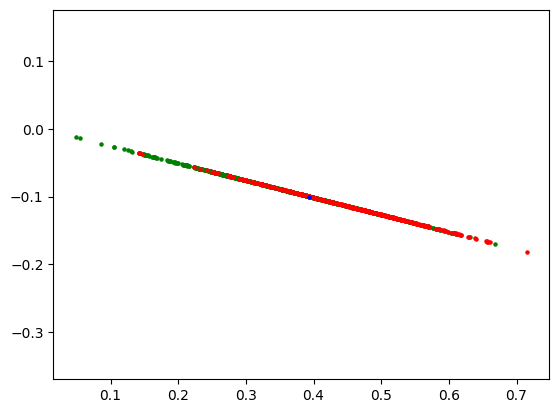

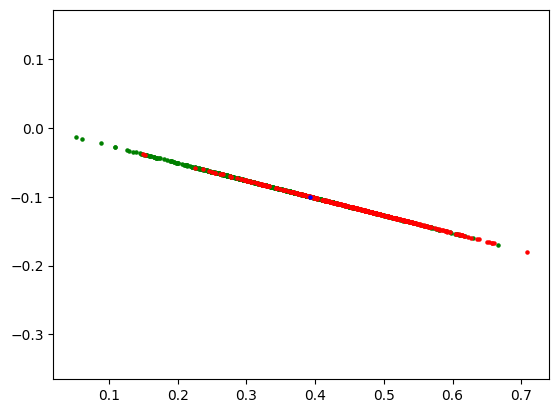

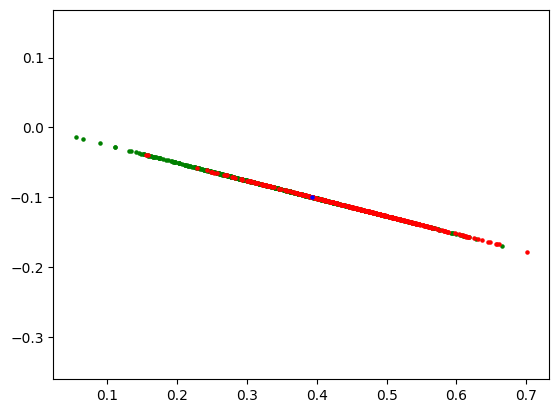

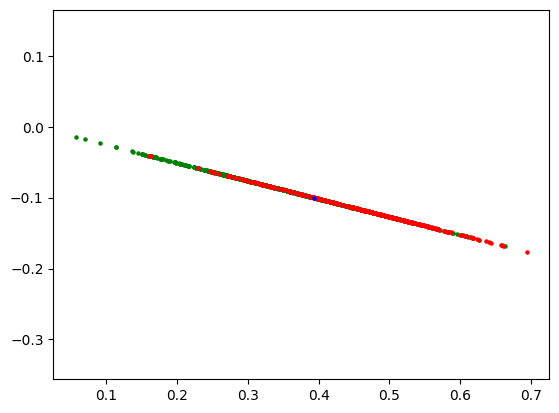

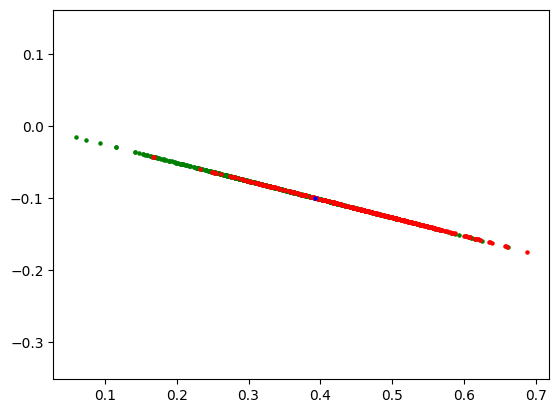

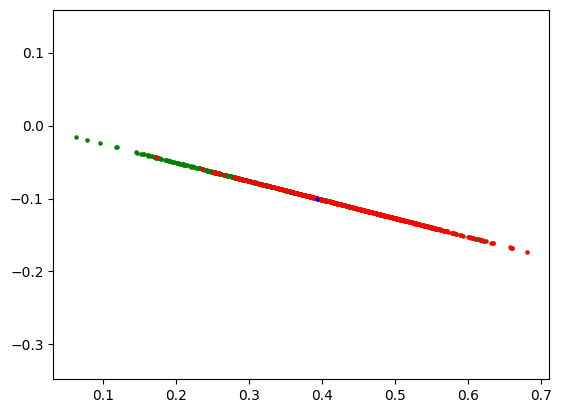

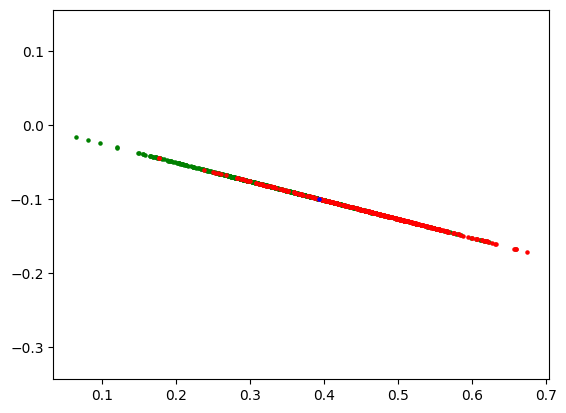

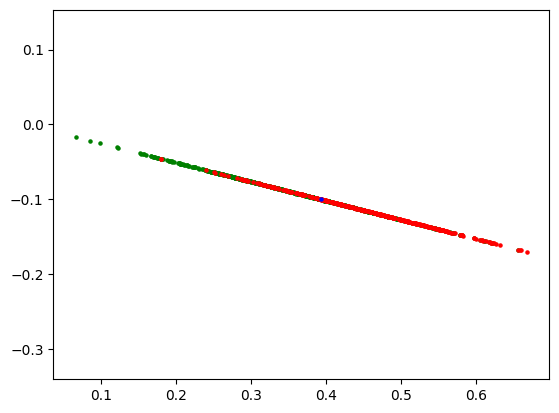

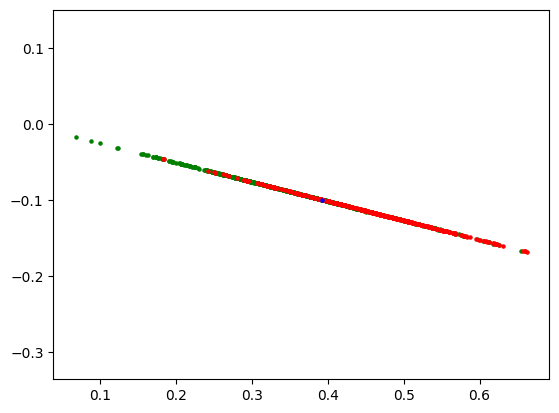

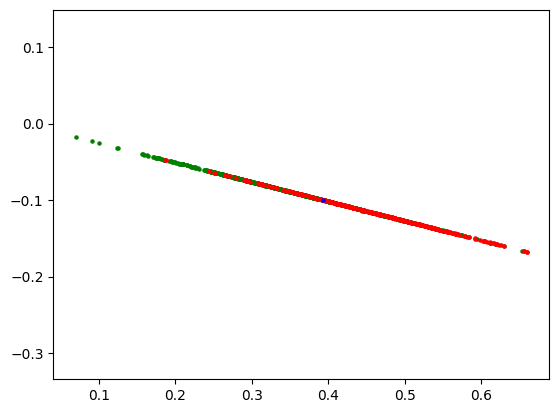

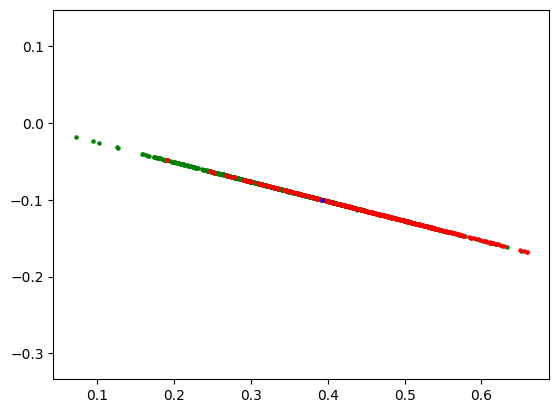

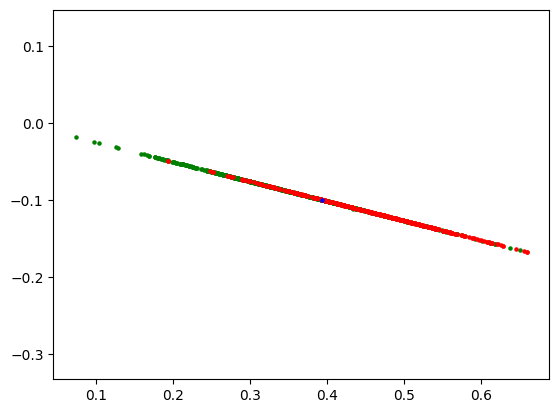

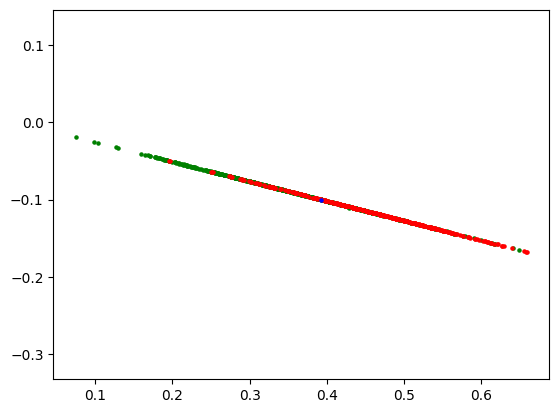

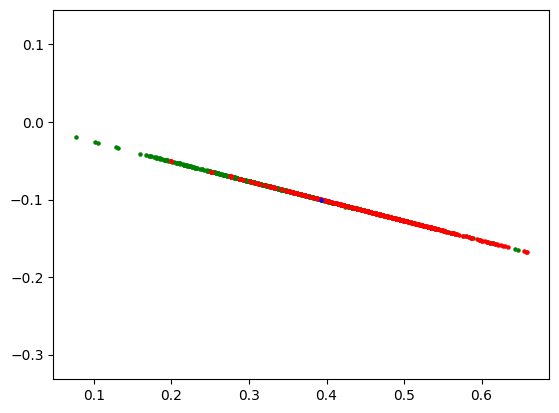

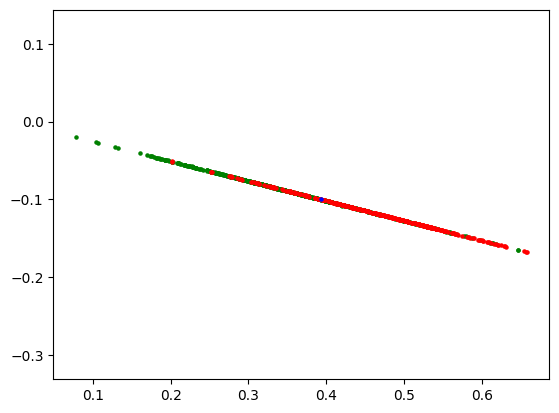

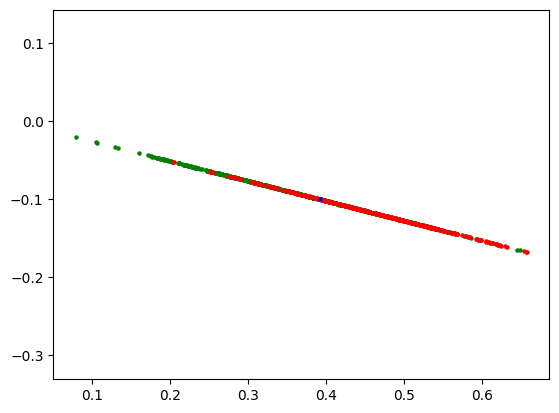

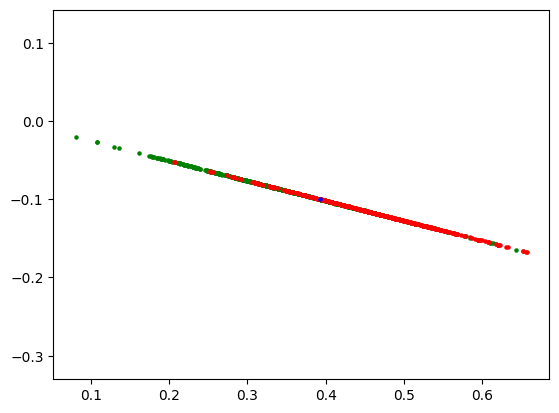

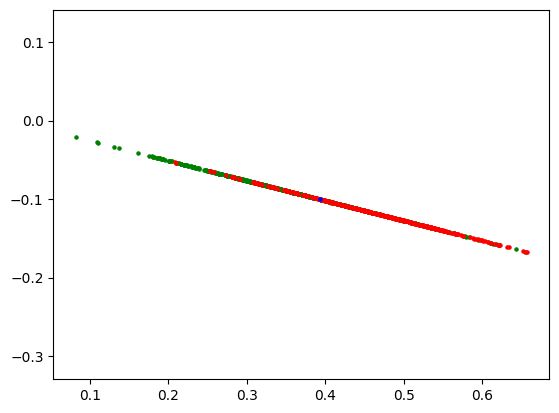

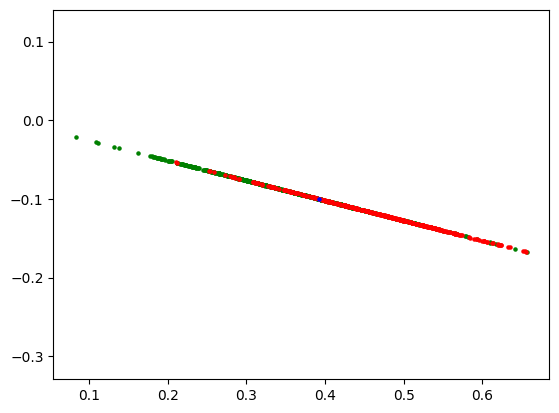

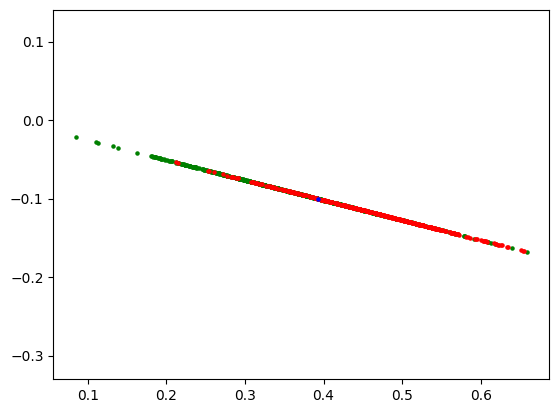

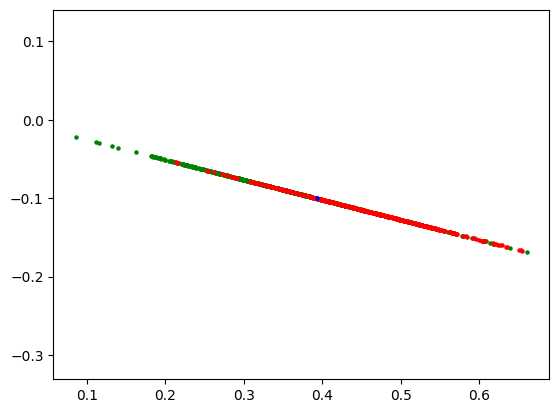

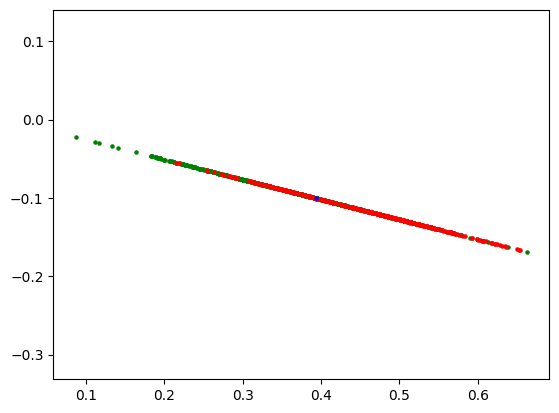

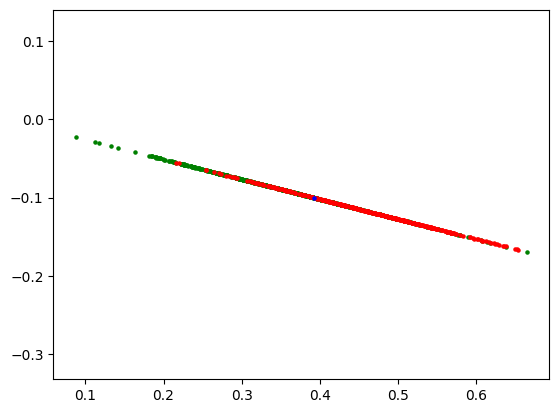

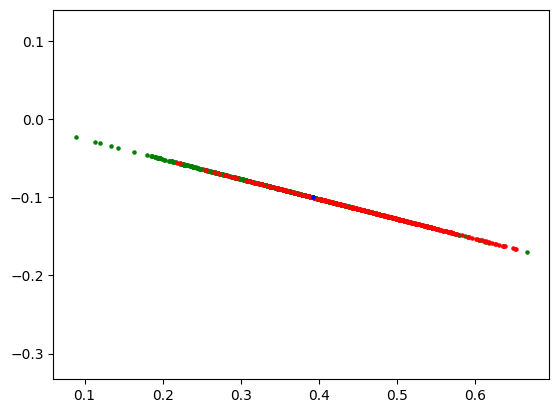

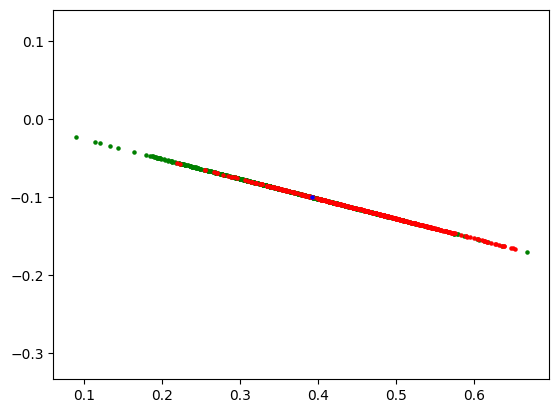

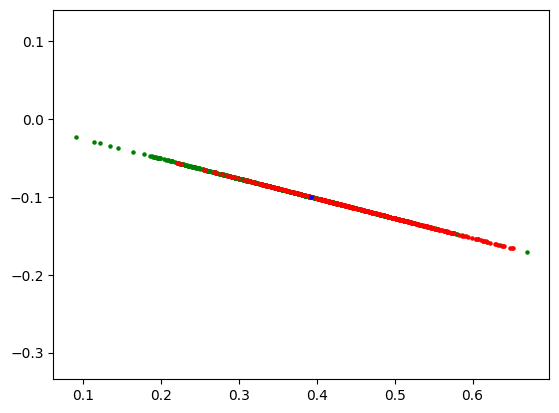

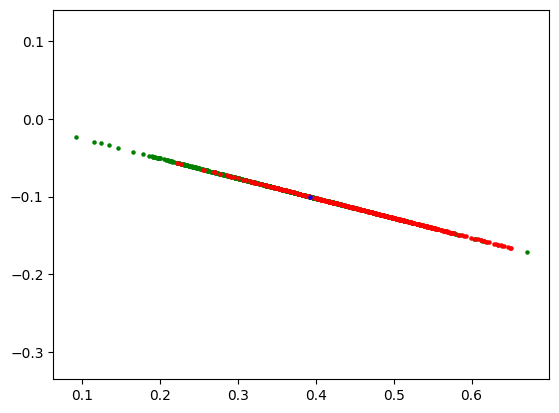

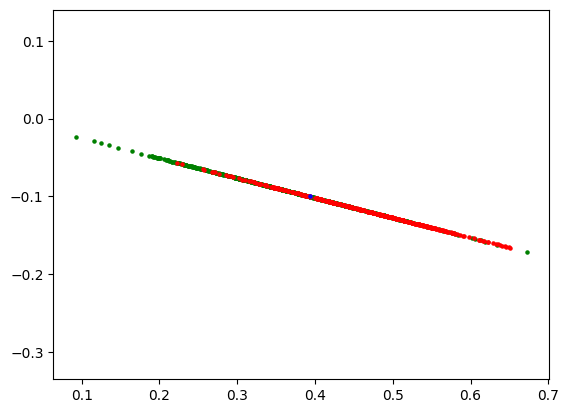

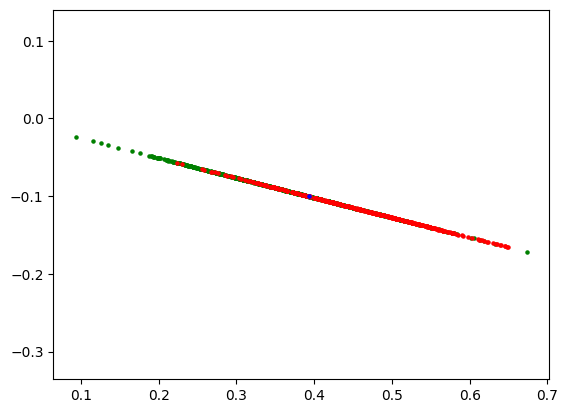

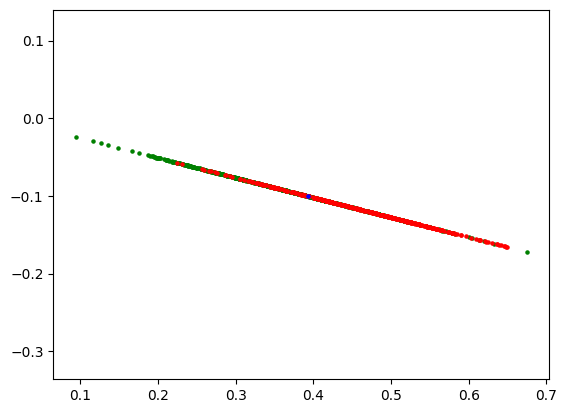

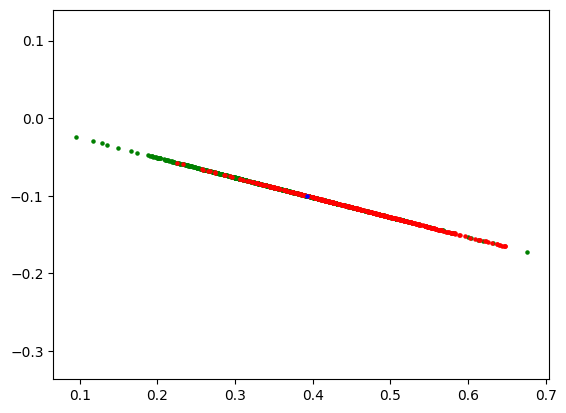

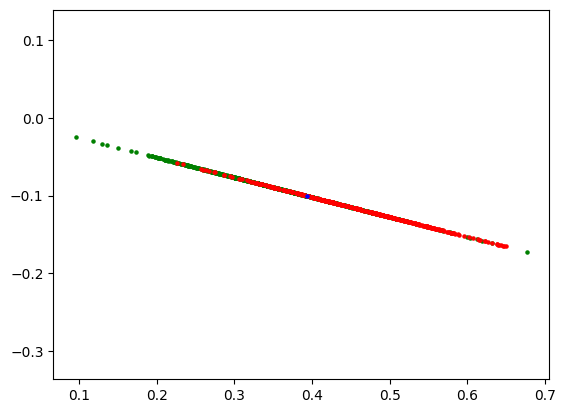

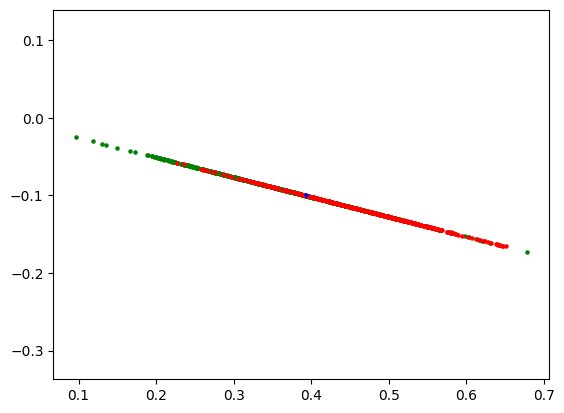

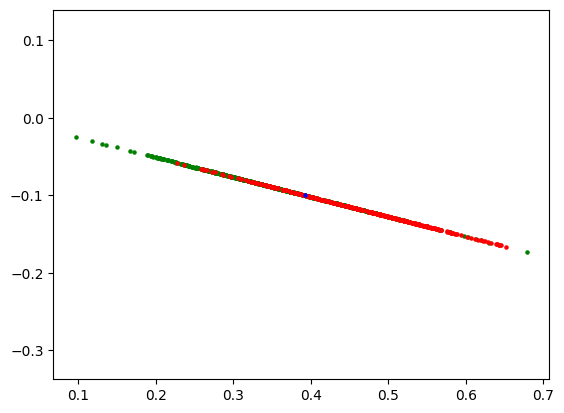

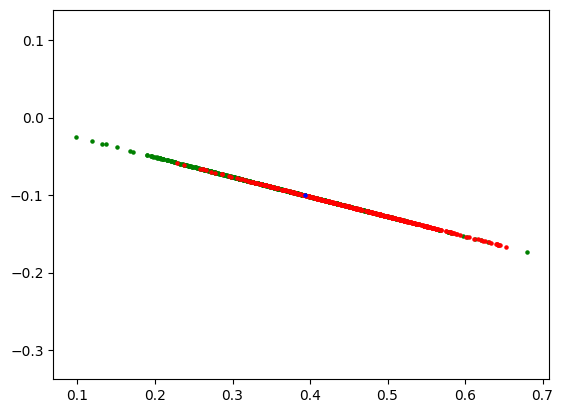

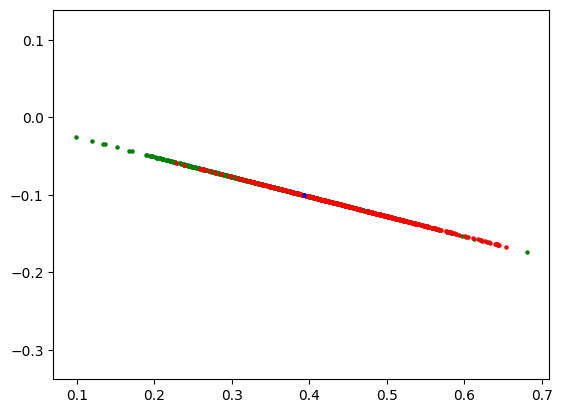

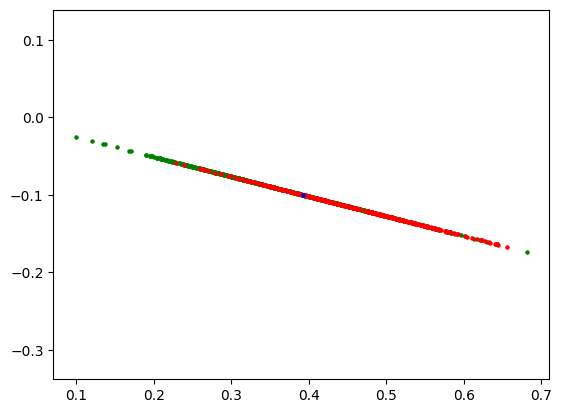

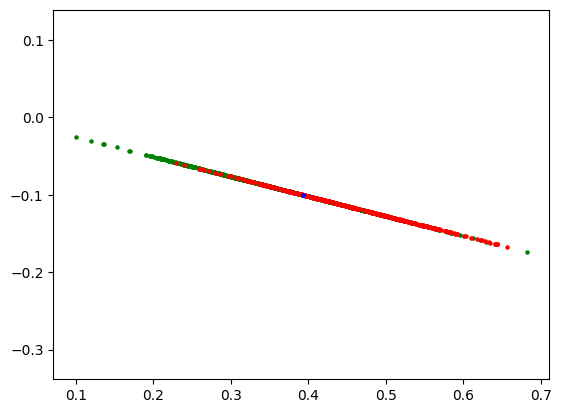

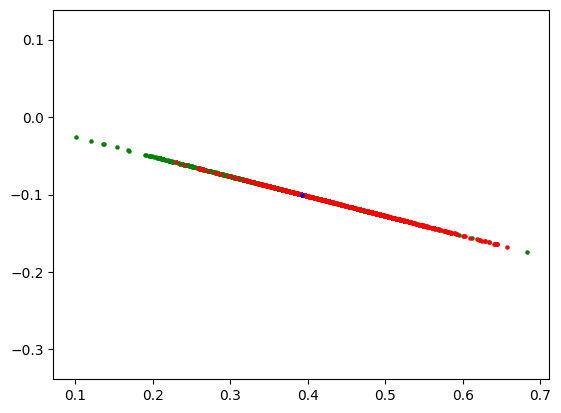

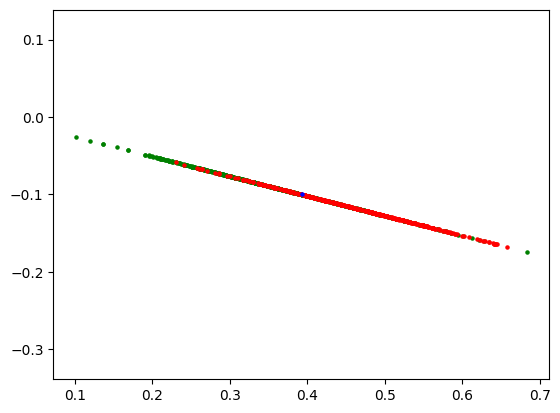

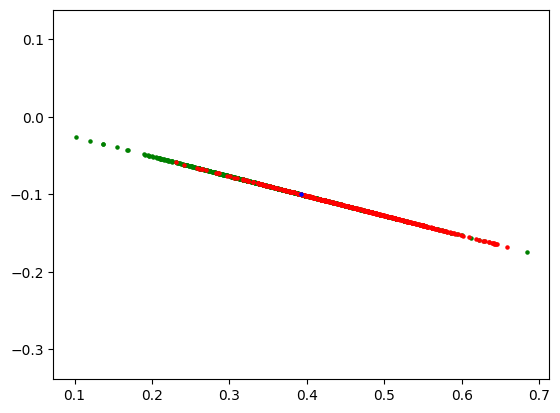

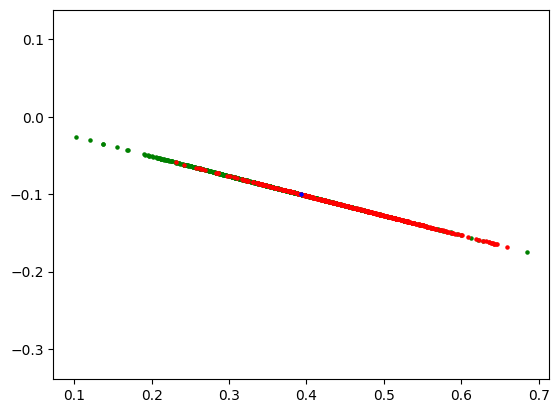

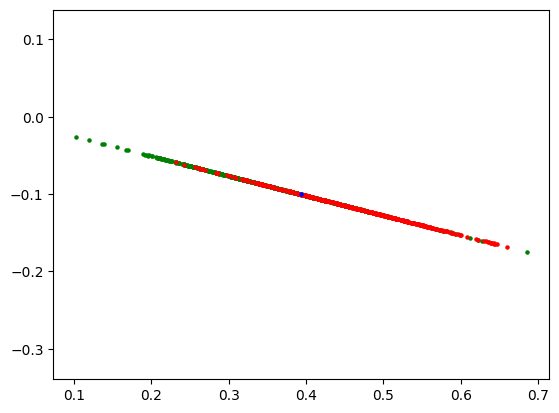

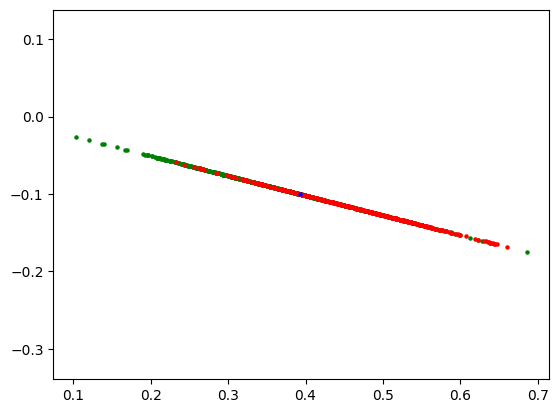

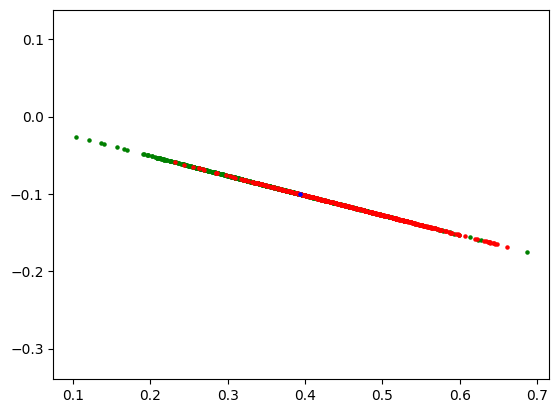

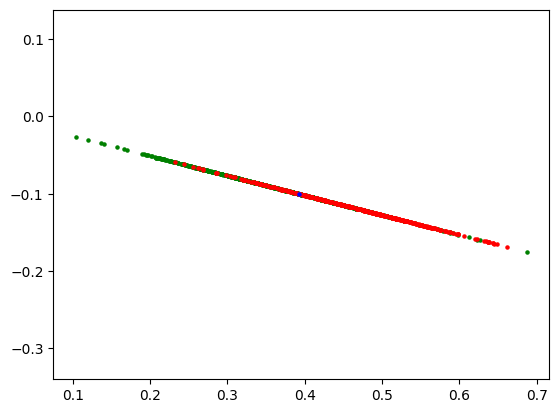

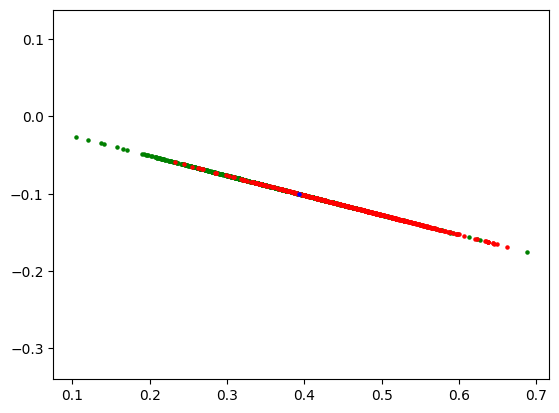

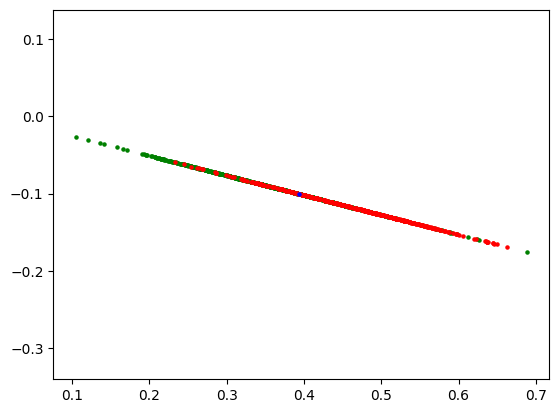

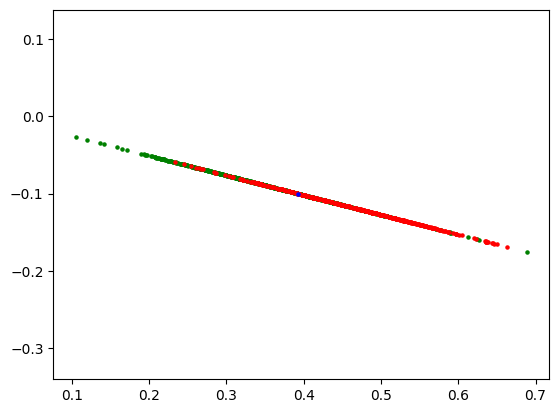

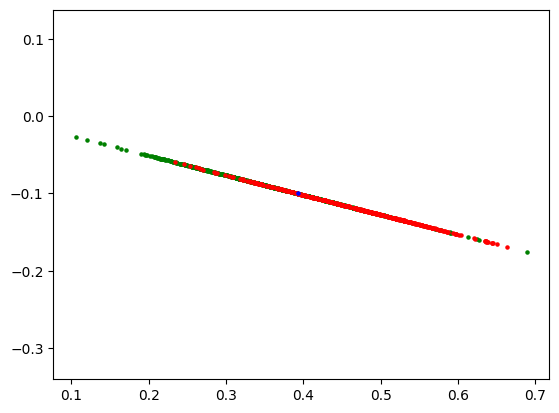

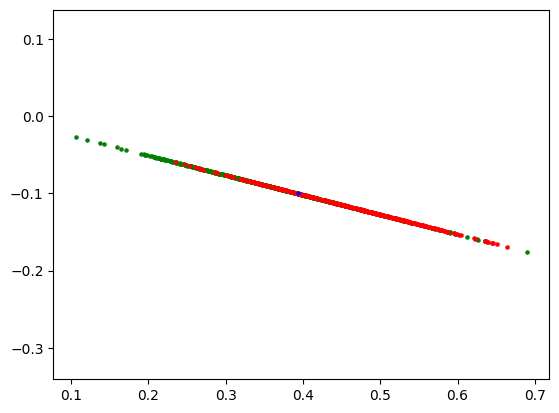

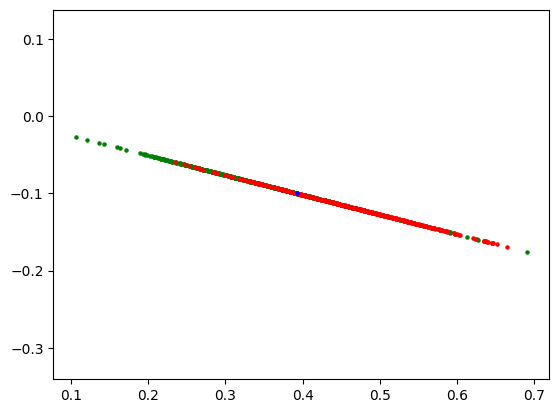

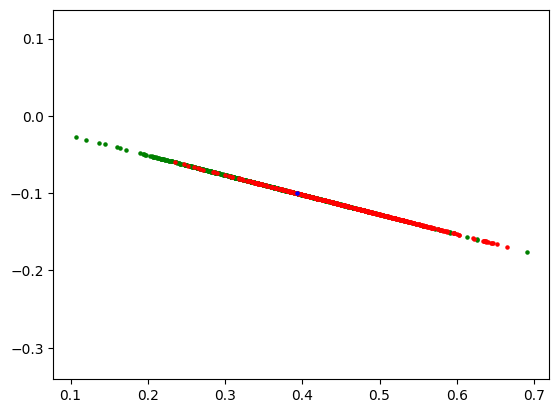

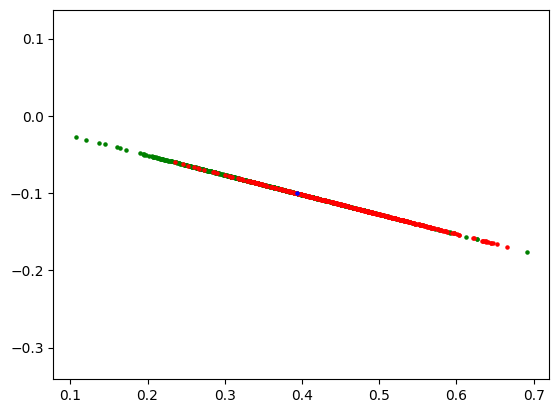

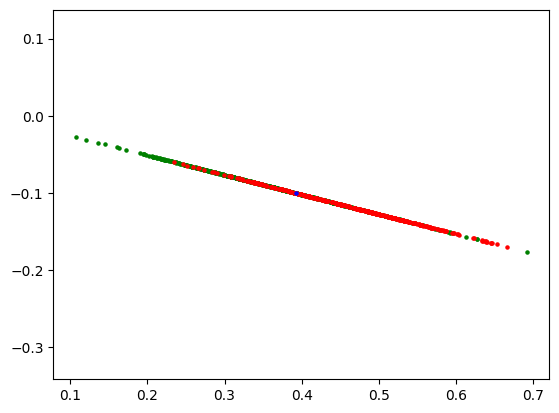

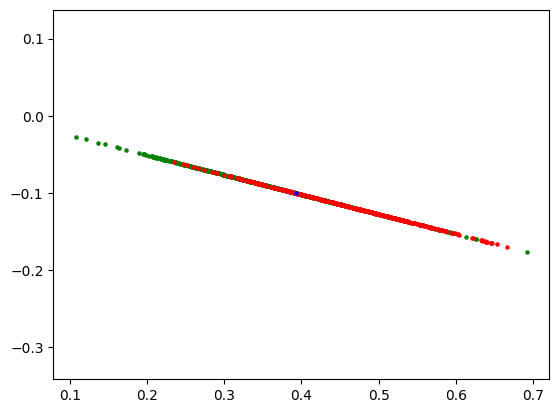

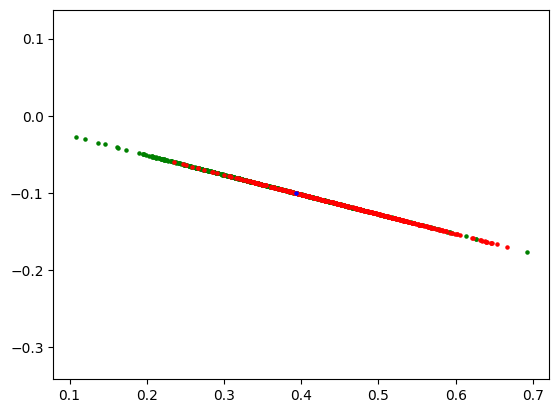

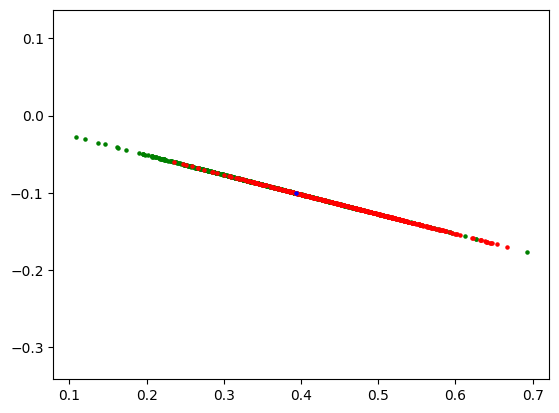

In [ ]:
from numpy import sqrt, quantile


class DeepSVDD(nn.Module):
    def __init__(self, autoencoder):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(5, 5, bias=False),
            nn.LeakyReLU(),
            nn.Linear(5, 5, bias=False),
            nn.LeakyReLU(),
            nn.Linear(5, 2, bias=False),
        ).to(device)
        net_dict = self.state_dict()
        ae_dict = autoencoder.state_dict()
        ae_dict = {k: v for k, v in ae_dict.items() if k in net_dict}
        net_dict.update(ae_dict)
        self.load_state_dict(net_dict)

    def forward(self, x):
        return self.layers(x)


# Trainer can train models for either soft-boundary Deep SVDD or One-Class Deep SVDD
class DeepSVDDTrainer:
    def __init__(self, model, goal, c_size):
        self.model = model
        self.goal = goal
        self.c = torch.tensor([0, 0], dtype=torch.float32, device=device)
        self.R = torch.tensor(0, dtype=torch.float32, device=device)

    def train(self, training_data):
        optimizer = torch.optim.Adam(dsvdd.parameters(), lr=1e-4,weight_decay=1e-5)
        train_loader = torch.utils.data.DataLoader(list(zip(training_data, training_data)), batch_size=1)
        warmup_epoch = 5
        nu = 0.1

        losses = []

        for epoch in range(100):
            epoch_loss = []
            keks = []
            for data in train_loader:
                inputs, targets = data
                optimizer.zero_grad()
                outputs = dsvdd.forward(inputs)
                dist = torch.sum((outputs - self.c) ** 2, dim=1)
                keks.append(dist.item())
                if self.goal == 'one-class':
                    loss = torch.mean(dist)
                else:
                    scores = dist - self.R ** 2
                    # Use default nu of 0.1 for now
                    loss = self.R ** 2 + (1 / nu) * torch.mean(torch.max(torch.zeros_like(scores), scores))
                loss.backward()
                optimizer.step()
                epoch_loss.append(loss.item())

                if epoch >= warmup_epoch and self.goal == 'soft-boundary':
                    self.R = torch.tensor(quantile(sqrt(keks), 1 - nu))
            losses.append(sum(epoch_loss) / len(epoch_loss))
            plot(self)
        return losses

    def set_center(self, transformed_data):
        eps = 0.1
        with torch.no_grad():
            self.c = torch.zeros(2, device='cuda')
            for x in transformed_data:
                self.c += dsvdd.forward(x)

            self.c /= len(transformed_data)
            self.c[(abs(self.c) < eps) & (self.c < 0)] = -eps
            self.c[(abs(self.c) < eps) & (self.c > 0)] = eps


    # First copy weights from autoencoder to DeepSVDD network


#mixin outliers with transformed data


dsvdd = DeepSVDD(ae)
dsvdd_trainer = DeepSVDDTrainer(dsvdd, 'one-class', 2)
dsvdd_trainer.set_center(tensors_circle)
plot(dsvdd_trainer)
dsvdd_trainer.train(tensors_circle)
